In [53]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- visualize given input data
- visualize output
- noisy data identification
- class imbalance

In [54]:
import sys
sys.path.append('..')

In [55]:
!pwd

/Users/akerke/Documents/stacked-unets/notebooks


In [80]:
import os
import cv2
import config
import numpy as np
import matplotlib.pyplot as plt
from src.utils import get_etci_df, visualize_image_and_masks, grayscale_to_rgb, sar_to_grayscale, cleanup_etci_data

In [57]:
config.train_dir

'/Users/akerke/Documents/stacked-unets/dataset/data-etci-flood/train'

In [58]:
train_df = get_etci_df(config.train_dir, "train")

In [59]:
train_df.shape

(33405, 6)

In [60]:
index = 100
df_row = train_df.iloc[index]

vv_image_path = df_row['vv_image_path']
vh_image_path = df_row['vh_image_path']
vv_image = cv2.imread(vv_image_path, 0) / 255.0
vh_image = cv2.imread(vh_image_path, 0) / 255.0

input_image = np.dstack((vv_image, vh_image)) 
print(input_image.shape)

(256, 256, 2)


In [61]:
vv_image_path

'/Users/akerke/Documents/stacked-unets/dataset/data-etci-flood/train/bangladesh_20170314t115609/tiles/vv/bangladesh_20170314t115609_x-11_y-20_vv.png'

In [62]:
output = np.transpose(input_image, (2, 0, 1)).astype('float32')
output.shape

(2, 256, 256)

In [63]:
rgb_image = grayscale_to_rgb(vv_image, vh_image)
rgb_image.shape

(256, 256, 3)

In [64]:
gray_image = sar_to_grayscale(vv_image, vh_image)
gray_image.shape

(256, 256)

In [65]:
np.expand_dims(gray_image, axis=0).astype('float32').shape

(1, 256, 256)

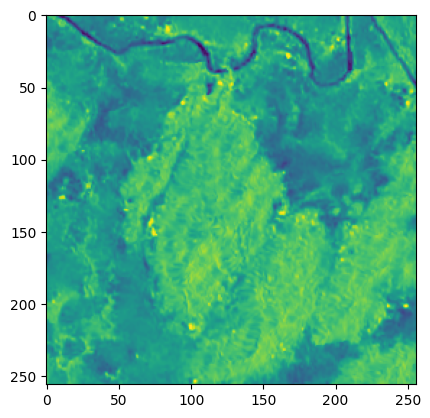

In [66]:
plt.imshow(gray_image)

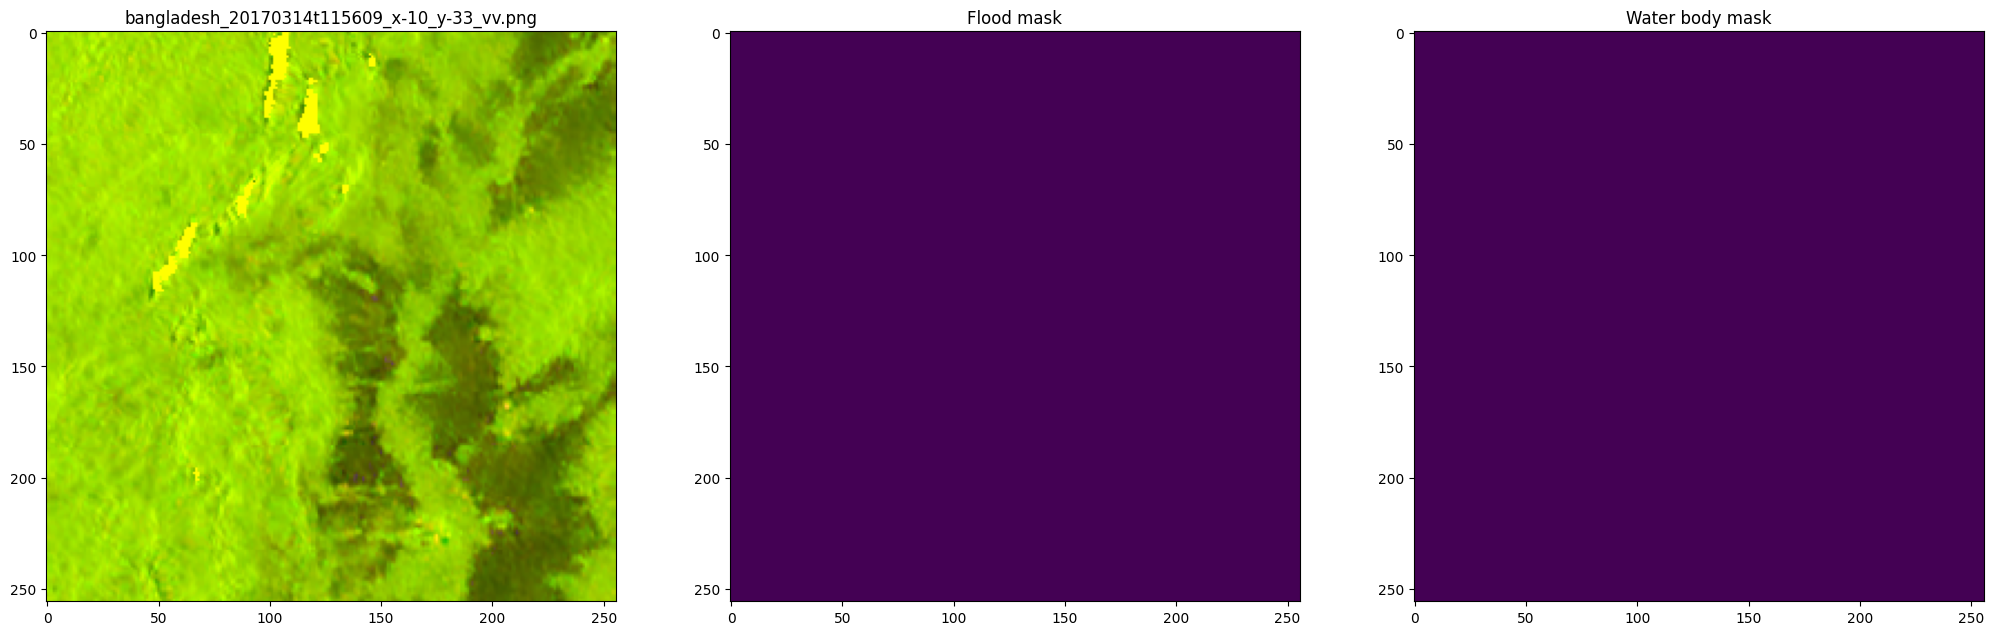

In [67]:
index = 70
visualize_image_and_masks(train_df.iloc[index])

### Visualize train data

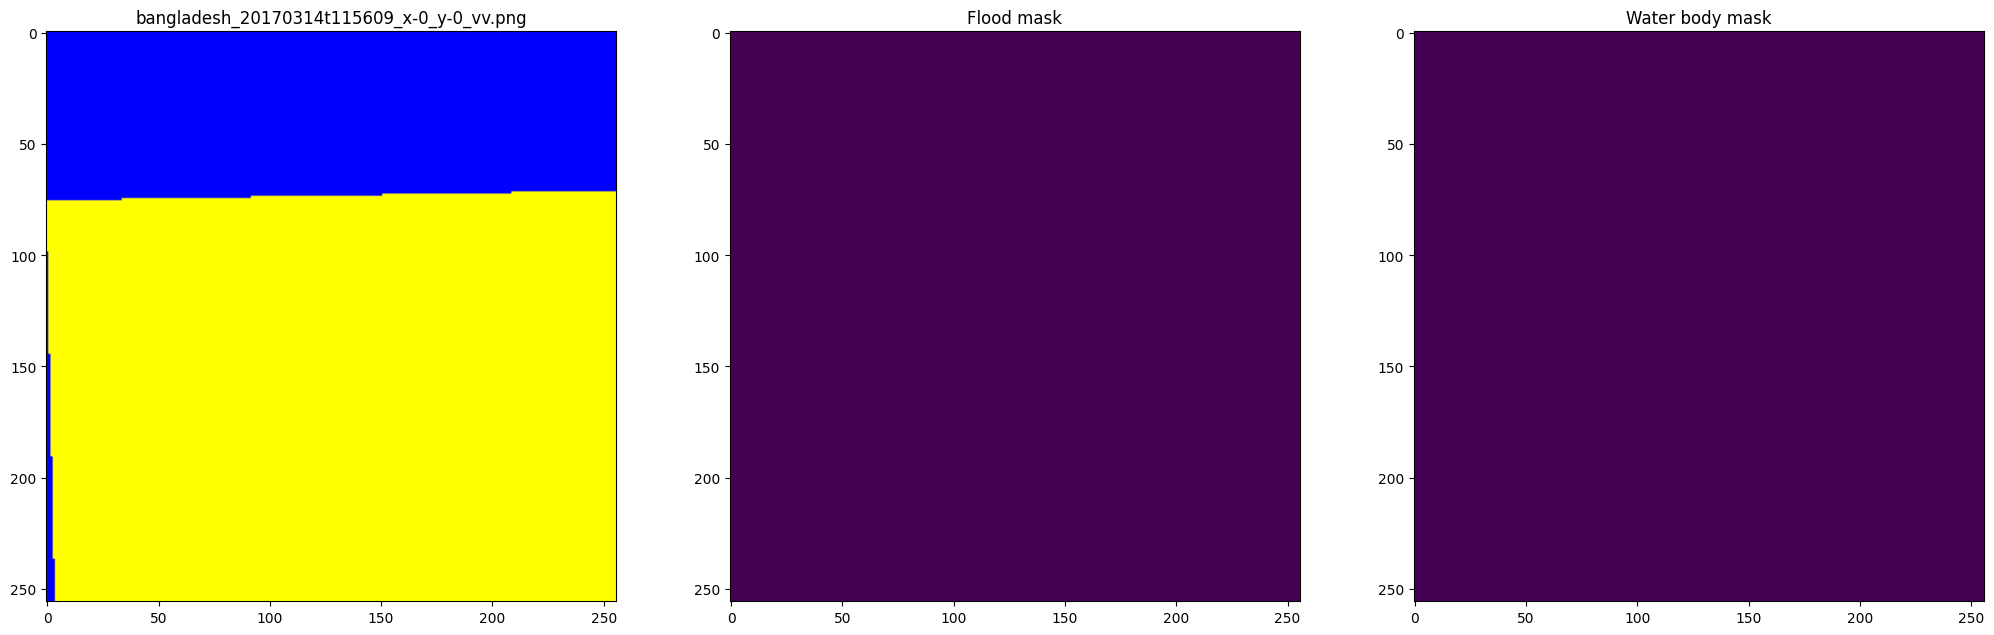

In [68]:
index = 0

visualize_image_and_masks(train_df.iloc[index])

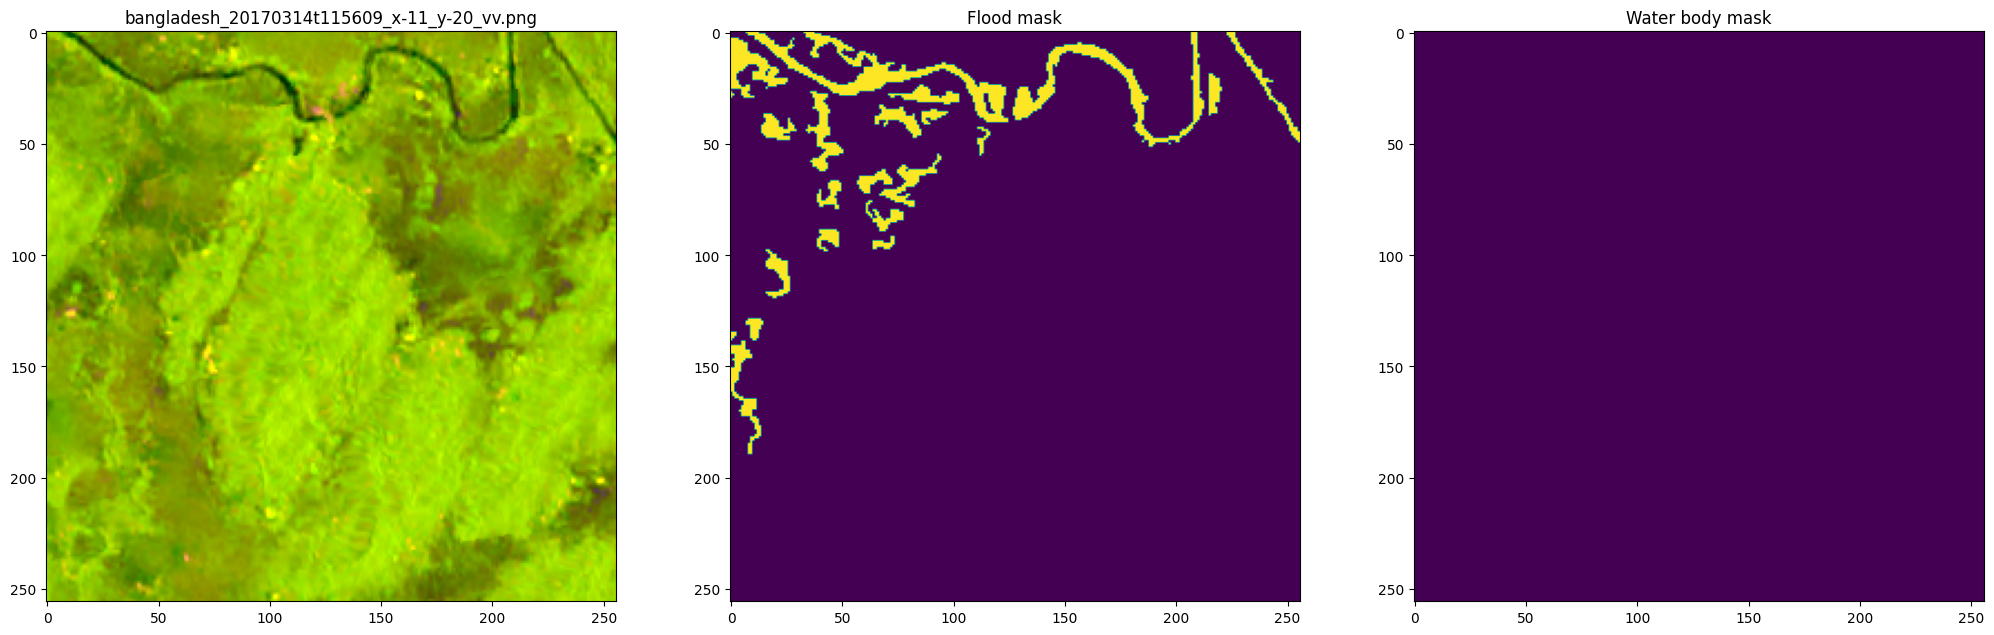

In [69]:
index = 100

visualize_image_and_masks(train_df.iloc[index])

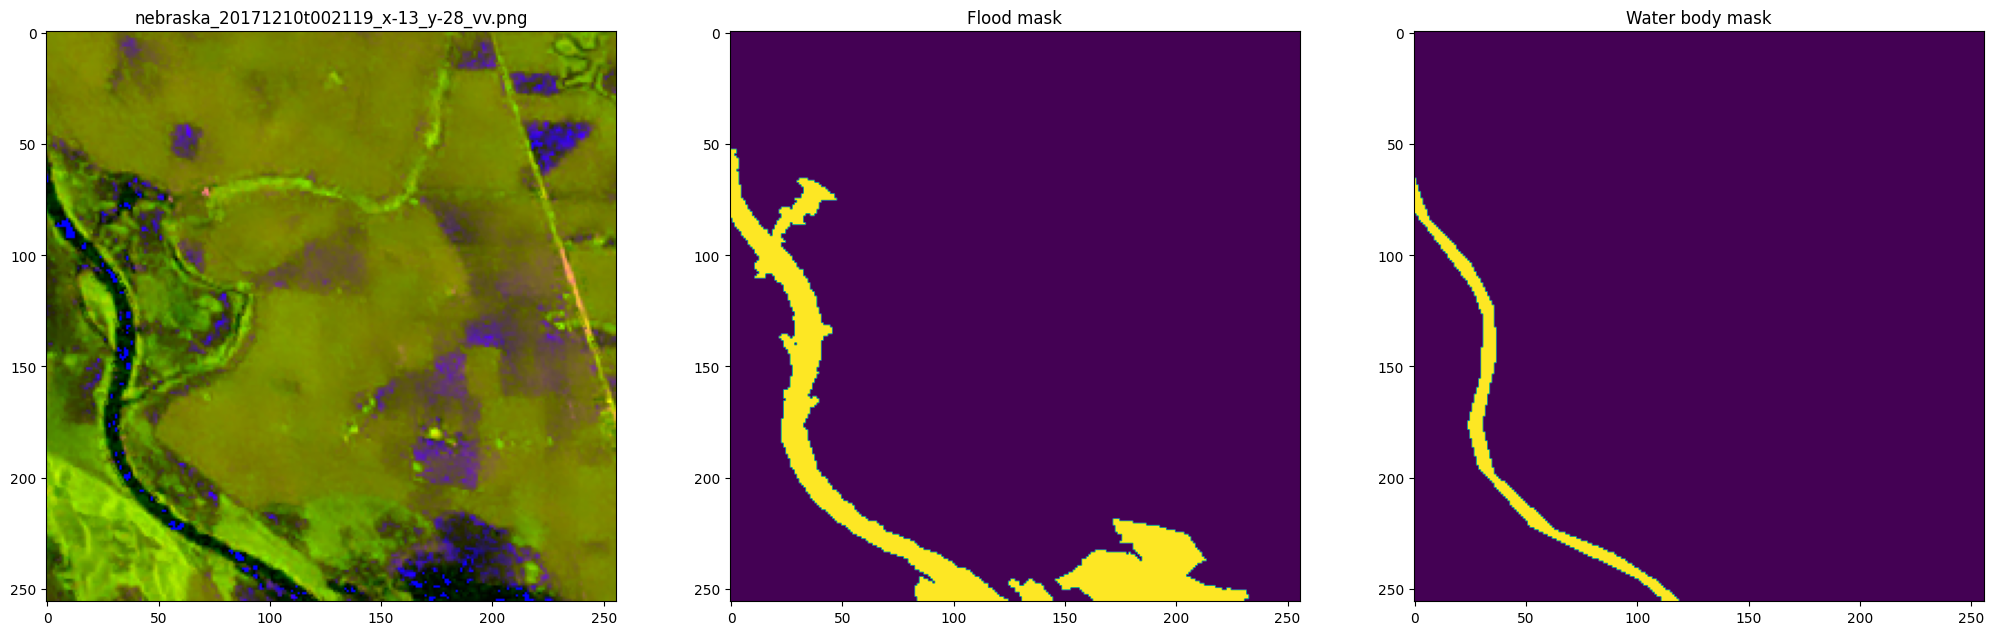

In [70]:
index = 16601

visualize_image_and_masks(train_df.iloc[index])

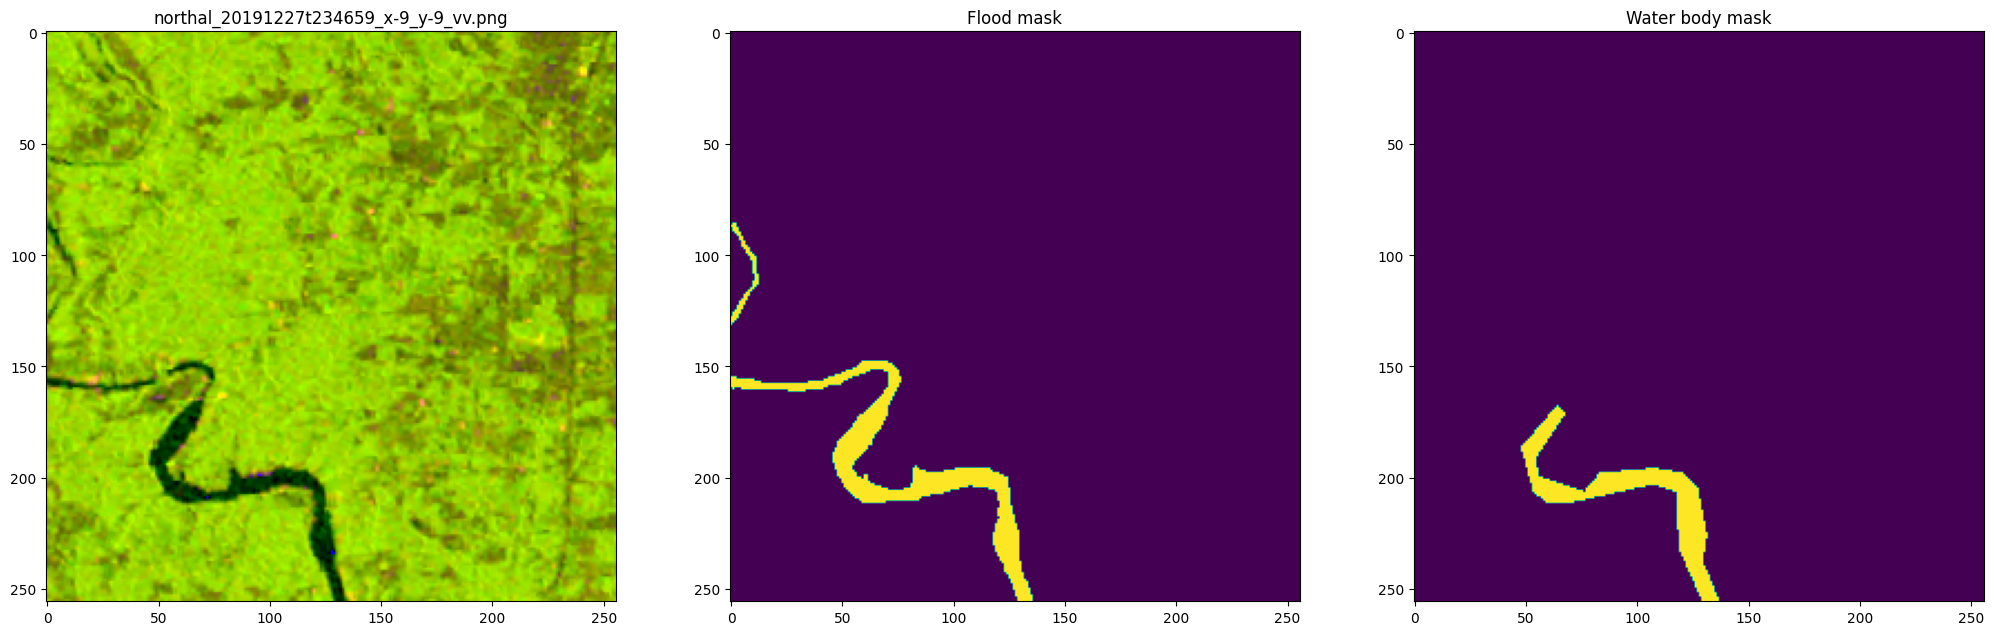

In [71]:
index = -1

visualize_image_and_masks(train_df.iloc[index])

#### Noisy data

some tiles at the edge of the collected SAR images contain no information and have not been removed.
These images contain all 0 or 255 values without any terrain features.

In [72]:
import cv2
import numpy as np

examples = [0,1,520,1000, 2882, 3550]

for point in examples:
    image_path = train_df.iloc[point]['vv_image_path']
    image = cv2.imread(image_path, 0) 
    image_unique_pixels = list(np.unique(image))
    print(image_unique_pixels)

[0, 255]
[0, 255]
[255]
[255]
[255]
[255]


In [73]:
noisy_points = []
for i, image_path in enumerate(train_df['vv_image_path'].tolist()):
    image = cv2.imread(image_path, 0)
    
    image_values = list(np.unique(image))

    binary_value_check = (image_values == [0,255]) or (image_values == [0]) or (image_values == [255])

    if binary_value_check is True:
        noisy_points.append(i)

In [74]:
len(noisy_points) / train_df.shape[0]

0.2508905852417303

In [75]:
print(train_df.shape)
filtered_train_df = train_df.drop(train_df.index[noisy_points])
print(filtered_train_df.shape)

(33405, 6)
(25024, 6)


In [81]:
project_root = '/Users/akerke/Documents/stacked-unets'
train_dir = os.path.join(project_root,'dataset', 'data-etci-flood','train')
original_df = get_etci_df(train_dir, split="train")
original_df = cleanup_etci_data(original_df)
original_df = original_df.reset_index(drop=True)

#### Class imbalance
Count Pixels: Go through each mask in your dataset and count the number of pixels that belong to each class (e.g., water and not-water). Sum these counts across all masks to get an overall count.If there is a significant imbalance you will see it here.

In [84]:
def viz_image_and_masks(df_row, figure_size=(25, 15)):
    flood_label_path = df_row['flood_label_path']
    flood_mask = cv2.imread(flood_label_path, cv2.IMREAD_GRAYSCALE) / 255.0

    water_pixels = np.sum(flood_mask == 1)
    non_water_pixels = np.sum(flood_mask == 0)

    plt.figure(figsize=figure_size)
    
    if df_row.isnull().sum() > 0:
        plt.subplot(1, 2, 1)
        plt.imshow(flood_mask, cmap='gray')
        plt.title(f"Flood Mask (Water Pixels: {water_pixels}, Non-water Pixels: {non_water_pixels})")
        
    else:
        plt.subplot(1, 3, 2)
        plt.imshow(flood_mask, cmap='gray')
        plt.title(f"Flood Mask (Water Pixels: {water_pixels}, Non-water Pixels: {non_water_pixels})")
        
    plt.show()

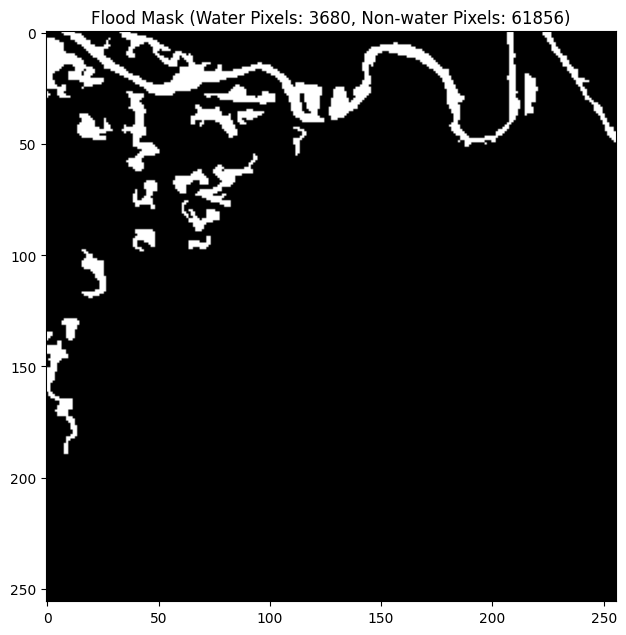

In [85]:
index = 100
viz_image_and_masks(train_df.iloc[index])

In [88]:
import cv2


total_water = 0
total_non_water = 0

for _, row in original_df.iterrows(): 
    flood_label_path = row['flood_label_path']
    flood_mask = cv2.imread(flood_label_path, cv2.IMREAD_GRAYSCALE)
    
    water_pixels = np.sum(flood_mask == 255)
    non_water_pixels = np.sum(flood_mask == 0)

    total_water += water_pixels
    total_non_water += non_water_pixels

print(f"Total water pixels: {total_water}")
print(f"Total non-water pixels: {total_non_water}")
total_pixels = total_water + total_non_water
percentage_water = (total_water / total_pixels) * 100
print(f"Percentage of water pixels: {percentage_water}%")

Total water pixels: 34261728
Total non-water pixels: 1605711136
Percentage of water pixels: 2.0891643241238413%
